# ECG-Pytorch-Ver2.0

@create 2021-09-13
@author 孙寒石
@env Pytorch 1.9.0 Python 3.7

## Import Packages

In [78]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [79]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
    
X=np.array(X)
y=np.array(y)
X = standardization(X)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


In [80]:
batch_size = 16
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] # 取第0元素：长度
        self.x_train = torch.from_numpy(X_train).float().to("cuda")
        self.y_train = torch.from_numpy(y_train).long().to("cuda")
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] # 返回对应样本即可
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] # 取第0元素：长度
        self.x_test = torch.from_numpy(X_test).float().to("cuda")
        self.y_test = torch.from_numpy(y_test).long().to("cuda")
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] # 返回对应样本即可
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Design Model

In [81]:
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,8,16,stride=2,padding=7),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8,stride=4),
   
            nn.Conv1d(8,12,12,padding=5,stride=2),
            nn.ReLU(),
            #nn.BatchNorm1d(16),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(12,32,9,stride=1,padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5,stride=2),
            
            nn.Conv1d(32,64,7,stride=1,padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(64,64,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,72,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            Flatten(),
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to(device)
from torchsummary import summary
summary(model, input_size=(1, 3600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 1800]             136
              ReLU-2              [-1, 8, 1800]               0
         MaxPool1d-3               [-1, 8, 449]               0
            Conv1d-4              [-1, 12, 224]           1,164
              ReLU-5              [-1, 12, 224]               0
         MaxPool1d-6              [-1, 12, 111]               0
            Conv1d-7              [-1, 32, 111]           3,488
              ReLU-8              [-1, 32, 111]               0
         MaxPool1d-9               [-1, 32, 54]               0
           Conv1d-10               [-1, 64, 54]          14,400
             ReLU-11               [-1, 64, 54]               0
        MaxPool1d-12               [-1, 64, 26]               0
           Conv1d-13               [-1, 64, 26]          20,544
             ReLU-14               [-1,

In [82]:
print(model)

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(2,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 12, kernel_size=(12,), stride=(2,), padding=(5,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(12, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(

## Construct Loss and Optimizer

In [83]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.0, amsgrad = False)

## Train

In [130]:
correct_list = []
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print('[%d, %5d] loss: %.8f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    correct_list.append(100 * correct / total)
    print('Accuracy on test set: %.8f %%' % (100 * correct / total))
    
    
for epoch in range(20):
    train(epoch)
    test()

[1,    10] loss: 0.00038484
[1,    20] loss: 0.00120951
[1,    30] loss: 0.00047210
[1,    40] loss: 0.00070047
[1,    50] loss: 0.00114938
Accuracy on test set: 88.00000000 %
[2,    10] loss: 0.00065541
[2,    20] loss: 0.00062974
[2,    30] loss: 0.00063544
[2,    40] loss: 0.00049607
[2,    50] loss: 0.00035630
Accuracy on test set: 84.50000000 %
[3,    10] loss: 0.00045089
[3,    20] loss: 0.00039565
[3,    30] loss: 0.00071363
[3,    40] loss: 0.00032732
[3,    50] loss: 0.00106807
Accuracy on test set: 84.50000000 %
[4,    10] loss: 0.00056714
[4,    20] loss: 0.00069701
[4,    30] loss: 0.00038214
[4,    40] loss: 0.00098905
[4,    50] loss: 0.00172655
Accuracy on test set: 86.00000000 %
[5,    10] loss: 0.00127738
[5,    20] loss: 0.00233715
[5,    30] loss: 0.00136528
[5,    40] loss: 0.00255493
[5,    50] loss: 0.00156168
Accuracy on test set: 83.00000000 %
[6,    10] loss: 0.00143857
[6,    20] loss: 0.00126263
[6,    30] loss: 0.00100231
[6,    40] loss: 0.00069174
[6,    5

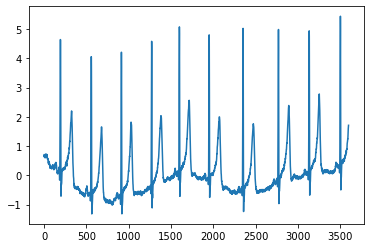

In [85]:
t=np.arange(3600)
p = X_train[1,:,:].reshape((3600))
plt.plot(t,p)

In [86]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([ 0,  2,  2,  3,  3,  6, 15,  3, 14,  6, 13, 14,  0,  0,  3,  0],
       device='cuda:0')
tensor([ 0,  1,  3,  3,  3,  6, 15,  3, 14,  6, 13,  1,  0,  0,  3, 12],
       device='cuda:0')
tensor([ 6,  6,  0,  0, 13, 14, 13,  1,  7,  3,  6,  0,  3,  0,  6, 13],
       device='cuda:0')
tensor([ 6,  6,  0,  0, 13, 14, 13,  1,  7,  3,  6,  0,  3,  0, 12,  0],
       device='cuda:0')
tensor([14,  0,  0,  2,  0,  3,  2,  0, 14,  3,  6, 13, 14, 16, 11,  3],
       device='cuda:0')
tensor([14, 13,  0,  2,  0,  3,  4,  0, 14,  3,  6, 13, 14, 16, 11,  3],
       device='cuda:0')
tensor([ 5,  5,  3,  0,  0, 15,  6,  9,  0, 13,  0, 10,  0, 10,  7,  3],
       device='cuda:0')
tensor([ 1,  5,  3,  0,  0,  6, 12,  9,  0, 13,  0, 10,  0, 10,  7, 13],
       device='cuda:0')
tensor([ 7,  0, 13,  7,  0,  3,  0,  3, 14,  0,  0, 13,  7, 10,  3,  0],
       device='cuda:0')
tensor([ 7,  0, 13,  7, 12,  3,  0,  3, 14,  0,  1, 13,  7, 10,  3,  0],
       device='cuda:0')
tensor([ 1,  0, 14,  3,  7,  0

Text(0, 0.5, 'Accuracy(%)')

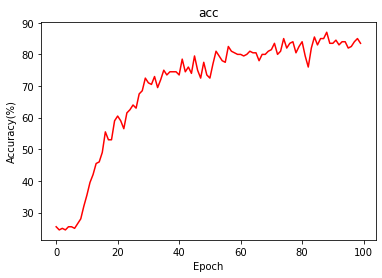

In [87]:
plt.rcParams['axes.grid'] = False
plt.plot(correct_list,'r')
plt.title('acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')

In [88]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Index of The Target Class',fontsize=13)
    plt.xlabel('Index of The Predicted Class',fontsize=13)

In [131]:
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
conf_matrix = torch.zeros(17, 17)

In [134]:
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        out = model(images)
        prediction = torch.max(out, 1)[1]
        conf_matrix = confusion_matrix(prediction, labels=labels, conf_matrix=conf_matrix)

Normalized confusion matrix
[[0.98251748 0.00699301 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.0034965  0.0034965  0.0034965  0.         0.        ]
 [0.015625   0.953125   0.         0.         0.         0.
  0.015625   0.         0.         0.         0.         0.
  0.015625   0.         0.         0.         0.        ]
 [0.         0.05263158 0.89473684 0.05263158 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.00735294 0.00735294 0.96323529 0.00735294 0.
  0.         0.         0.00735294 0.         0.         0.
  0.         0.00735294 0.         0.         0.        ]
 [0.         0.         0.14285714 0.         0.85714286 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.04347826 0.         0.04347826 0.         0.91304348
  0.         0

<Figure size 432x288 with 0 Axes>

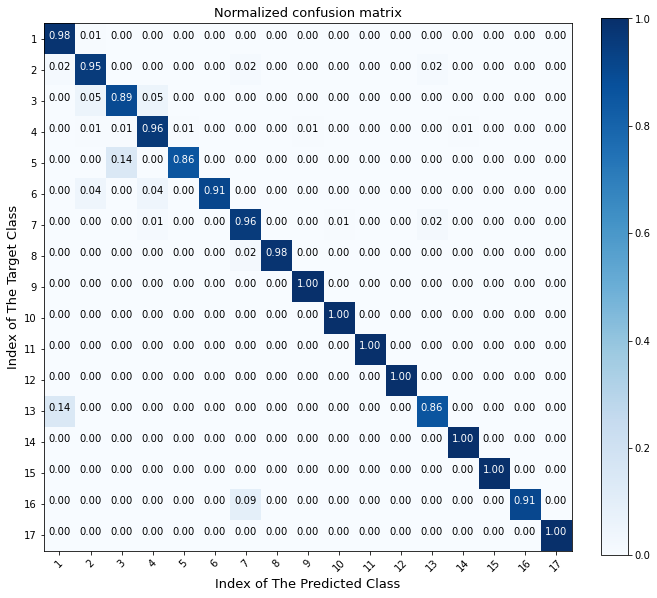

In [143]:
attack_types=['1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.tight_layout()
plt.figure(figsize=(9,8.5))
plot_confusion_matrix(conf_matrix.numpy(), classes=attack_types, normalize=True)
plt.title('Normalized confusion matrix',fontsize=13)
plt.savefig(fname="Confusion-matrix.pdf",format="pdf",bbox_inches = 'tight')

## Param Picture

In [15]:
#model = arrhythmia_classifier()
#model.load_state_dict(torch.load('ECGNet_model_q.pth'))
#model.state_dict().keys()

In [16]:
model.cnn[0].weight.view((8,16))

tensor([[ 0.2119, -0.1158, -0.2040,  0.2029,  0.1268, -0.0417, -0.1562,  0.1416,
          0.1253, -0.2198, -0.1995,  0.0301, -0.0856, -0.3253, -0.2162, -0.0904],
        [-0.0194, -0.1965, -0.1114,  0.1164, -0.2441, -0.1746, -0.2014, -0.0549,
         -0.2133, -0.2386, -0.1335, -0.1639, -0.0219, -0.1328, -0.0842, -0.0105],
        [-0.0191,  0.1073, -0.1012,  0.1531,  0.2237,  0.2160,  0.1389,  0.1882,
          0.1761,  0.1174,  0.0299, -0.0054, -0.2320,  0.1735, -0.1356, -0.0769],
        [ 0.2280, -0.0048,  0.0461,  0.2263,  0.3027,  0.1355,  0.0216, -0.1919,
          0.1281, -0.1314, -0.2867, -0.2737,  0.1269, -0.1217, -0.1485, -0.0453],
        [-0.0055, -0.0015, -0.0889,  0.2599, -0.0866, -0.1366,  0.0430, -0.2900,
         -0.0671, -0.0161, -0.1075, -0.2683, -0.2105, -0.1622,  0.1136,  0.2824],
        [-0.1758, -0.1996,  0.0447, -0.1670, -0.1049, -0.2662,  0.0162, -0.0913,
         -0.2153, -0.2060,  0.1953,  0.2193,  0.0288,  0.0612,  0.3084,  0.2990],
        [ 0.2639,  0.2

In [17]:
first_layer = model.cnn[0].weight.view((8,16)).to("cpu").detach().numpy()

In [18]:
first_layer[0]

array([ 0.21186046, -0.1158446 , -0.20403798,  0.20293711,  0.12681746,
       -0.04170439, -0.15623082,  0.14159568,  0.12530237, -0.21983558,
       -0.19954409,  0.03011014, -0.08563738, -0.32533175, -0.21617183,
       -0.09042221], dtype=float32)

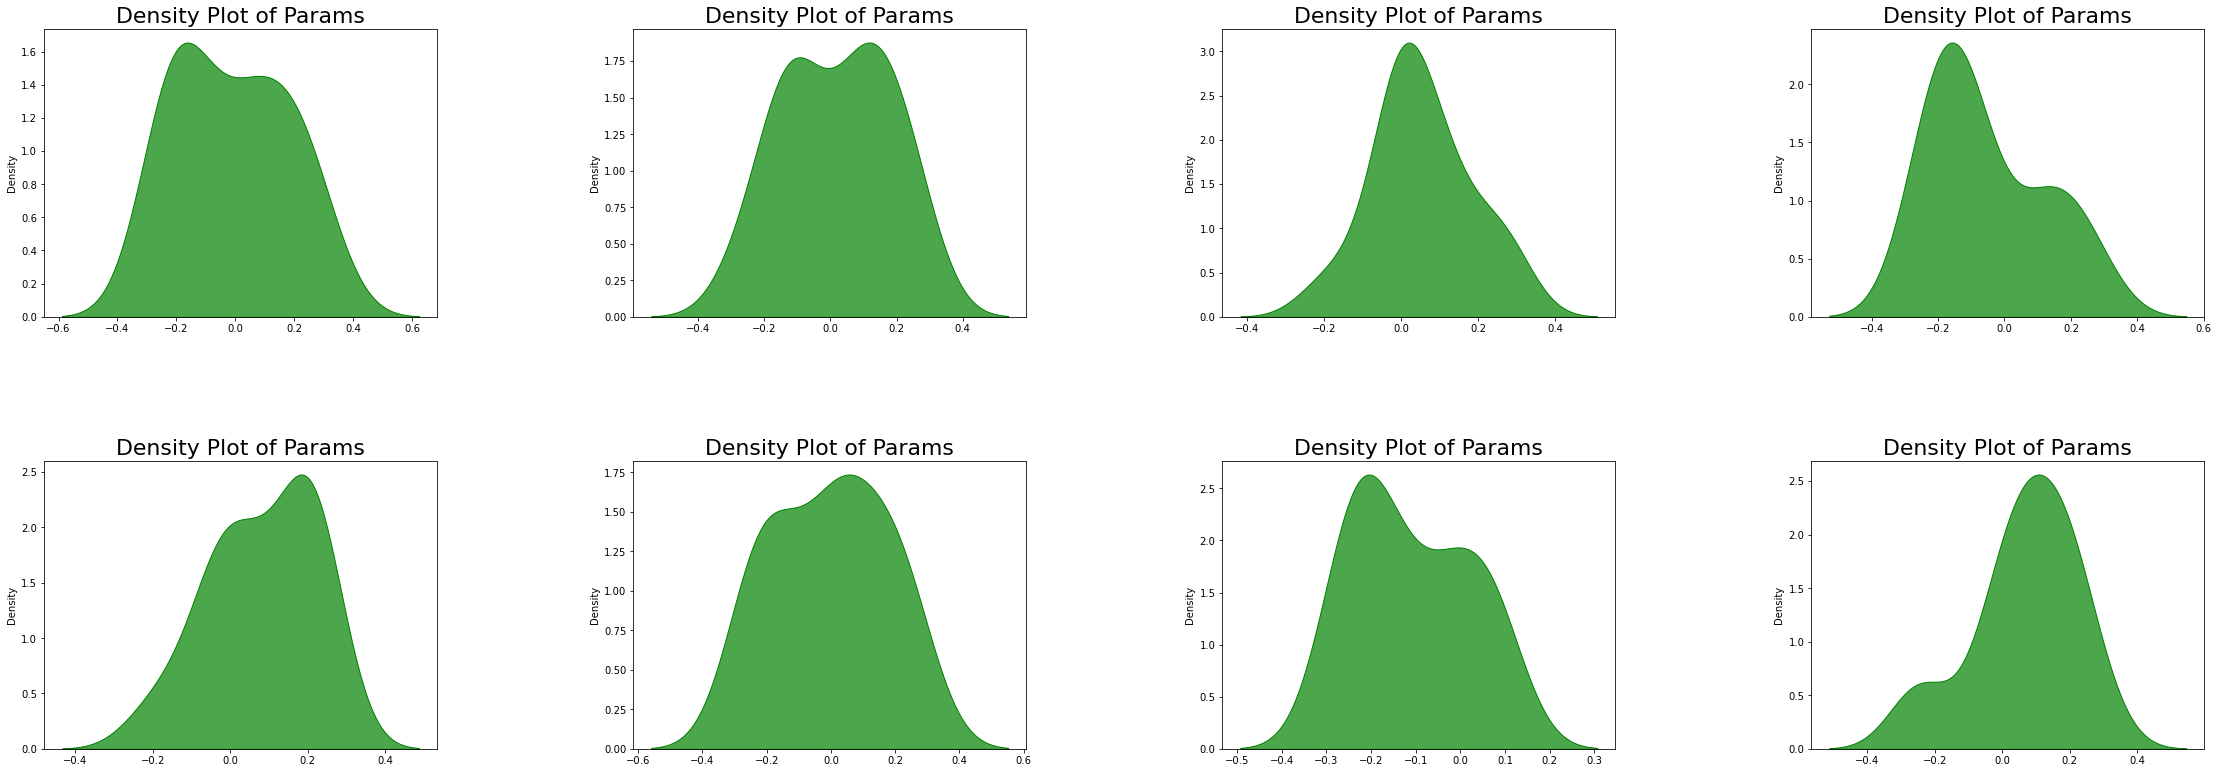

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# 密度图

# Draw Plot
#plt.subplot(2, 2, 1)
#plt.figure(figsize=(10,6), dpi= 80)
#sns.kdeplot(first_layer[0], shade=True, color="g", alpha=.7)
plt.subplots_adjust(left=0, bottom=0, right=5, top=2.5,
                wspace=0.5, hspace=0.5)
for i in range(8):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(first_layer[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

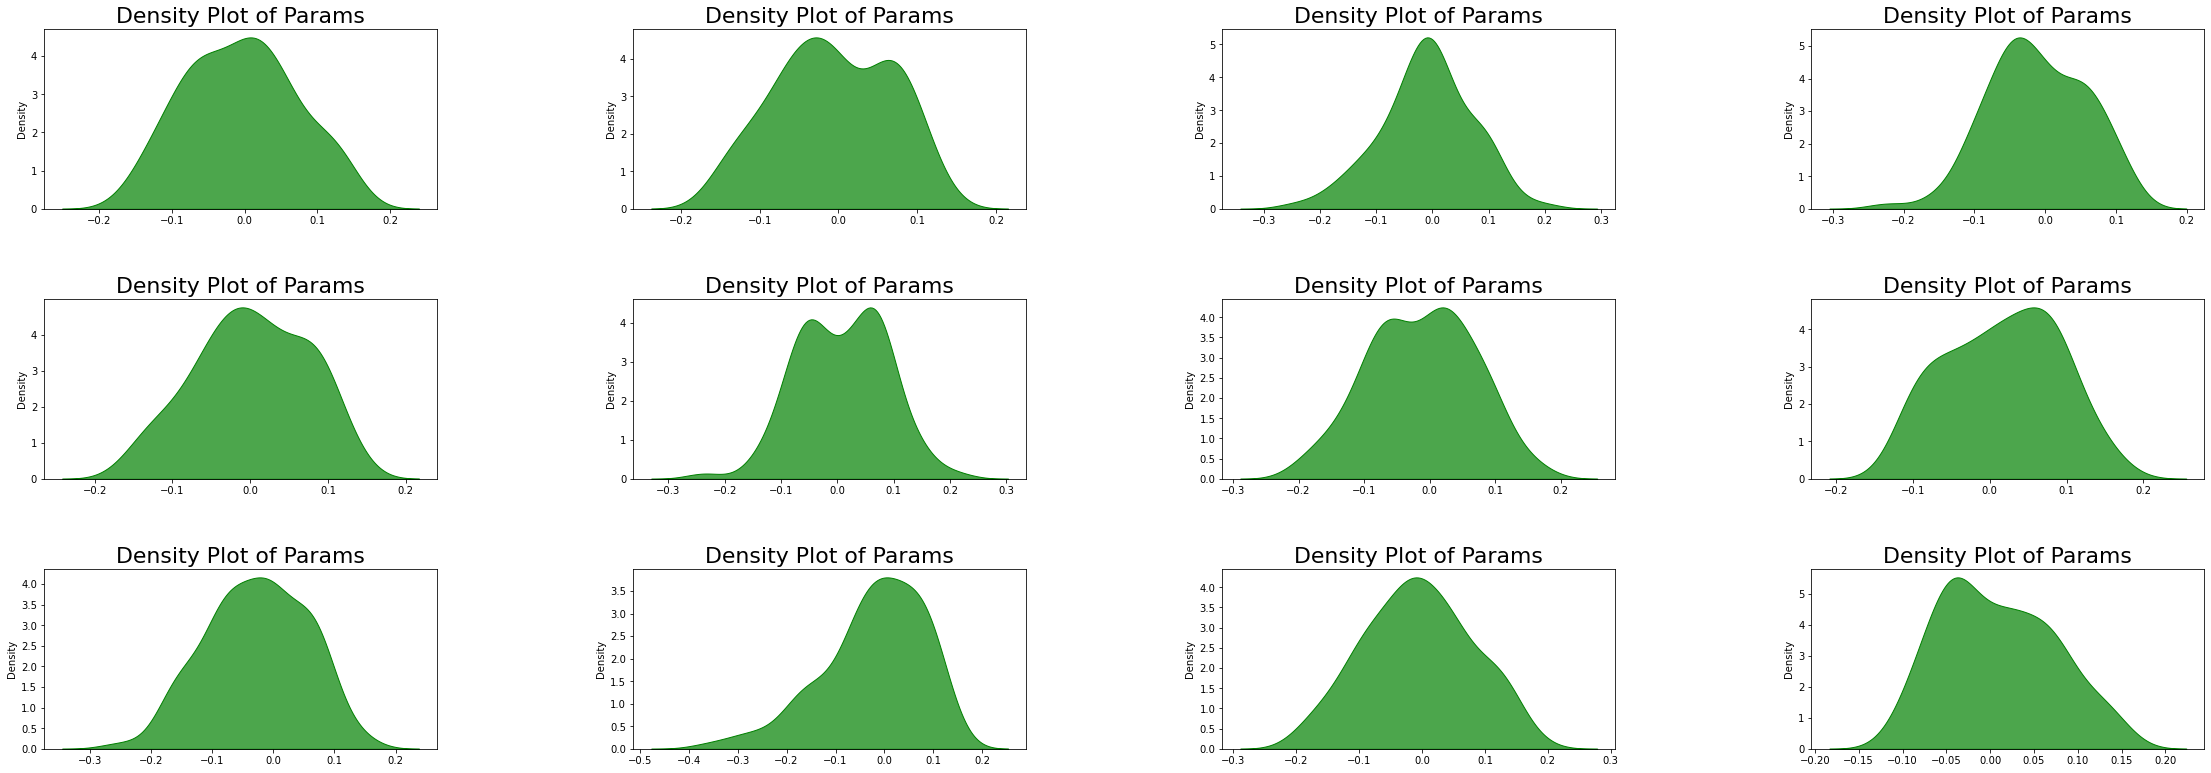

In [21]:
layer2 = model.cnn[3].weight.view((12,12*8)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=2.5,
                wspace=0.5, hspace=0.5)
for i in range(12):
    plt.subplot(3, 4, i+1)
    sns.kdeplot(layer2[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

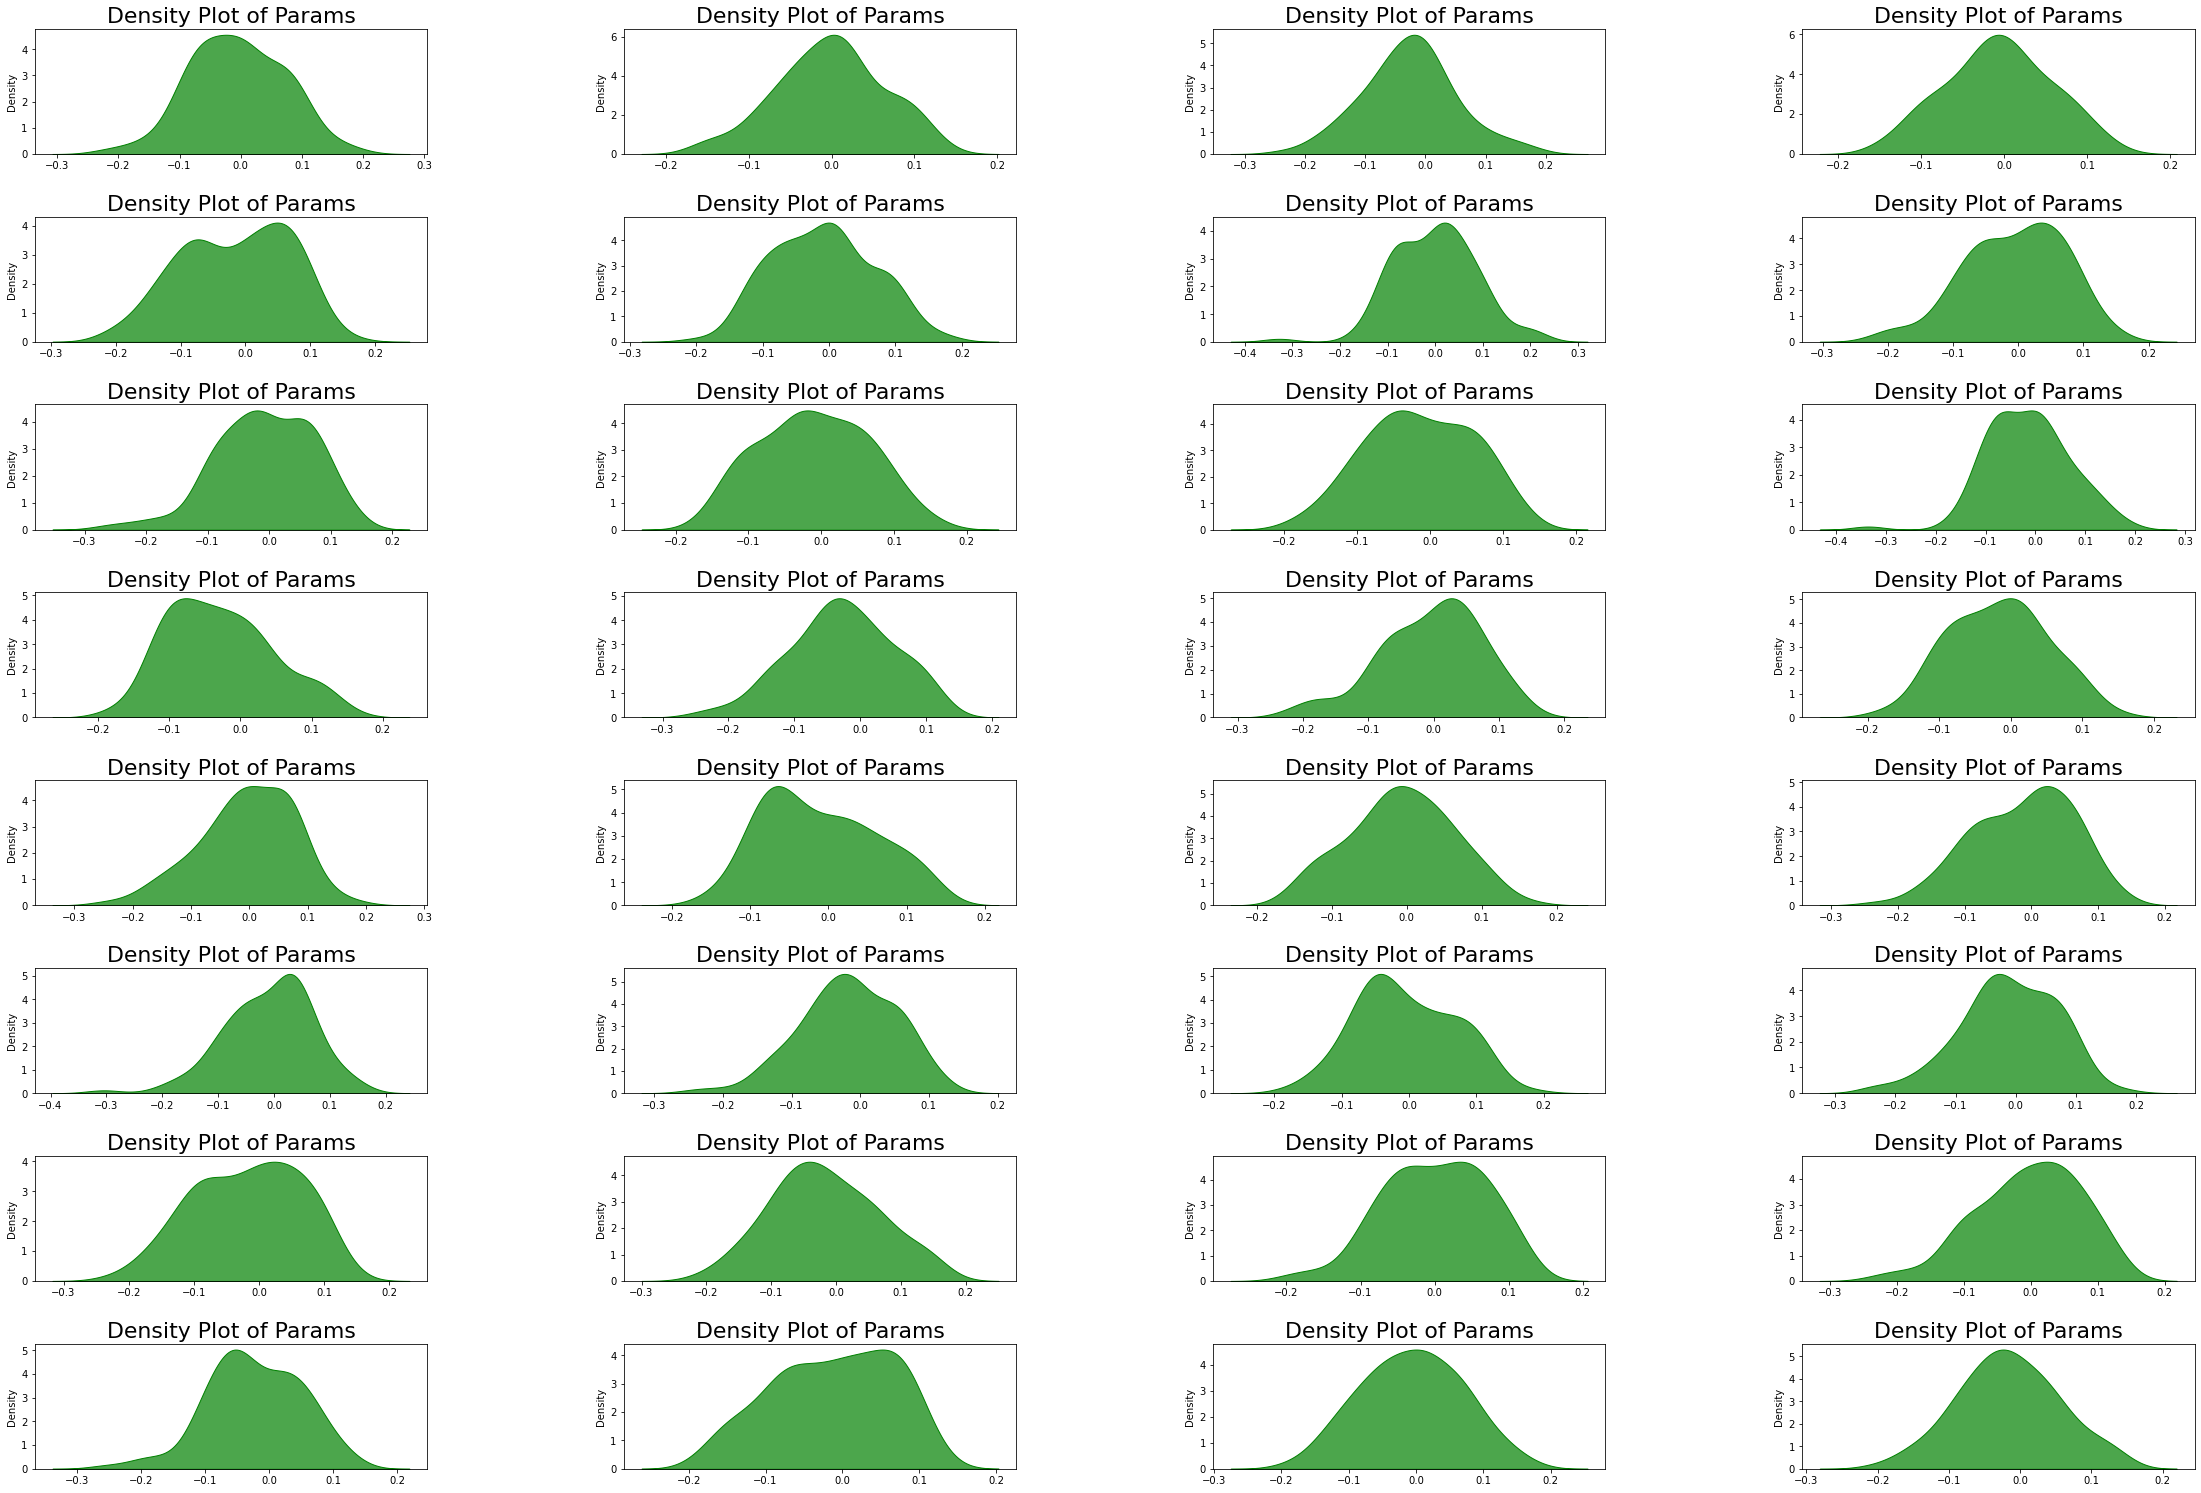

In [22]:
layer3 = model.cnn[6].weight.view((32,12*9)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(32):
    plt.subplot(8, 4, i+1)
    sns.kdeplot(layer3[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

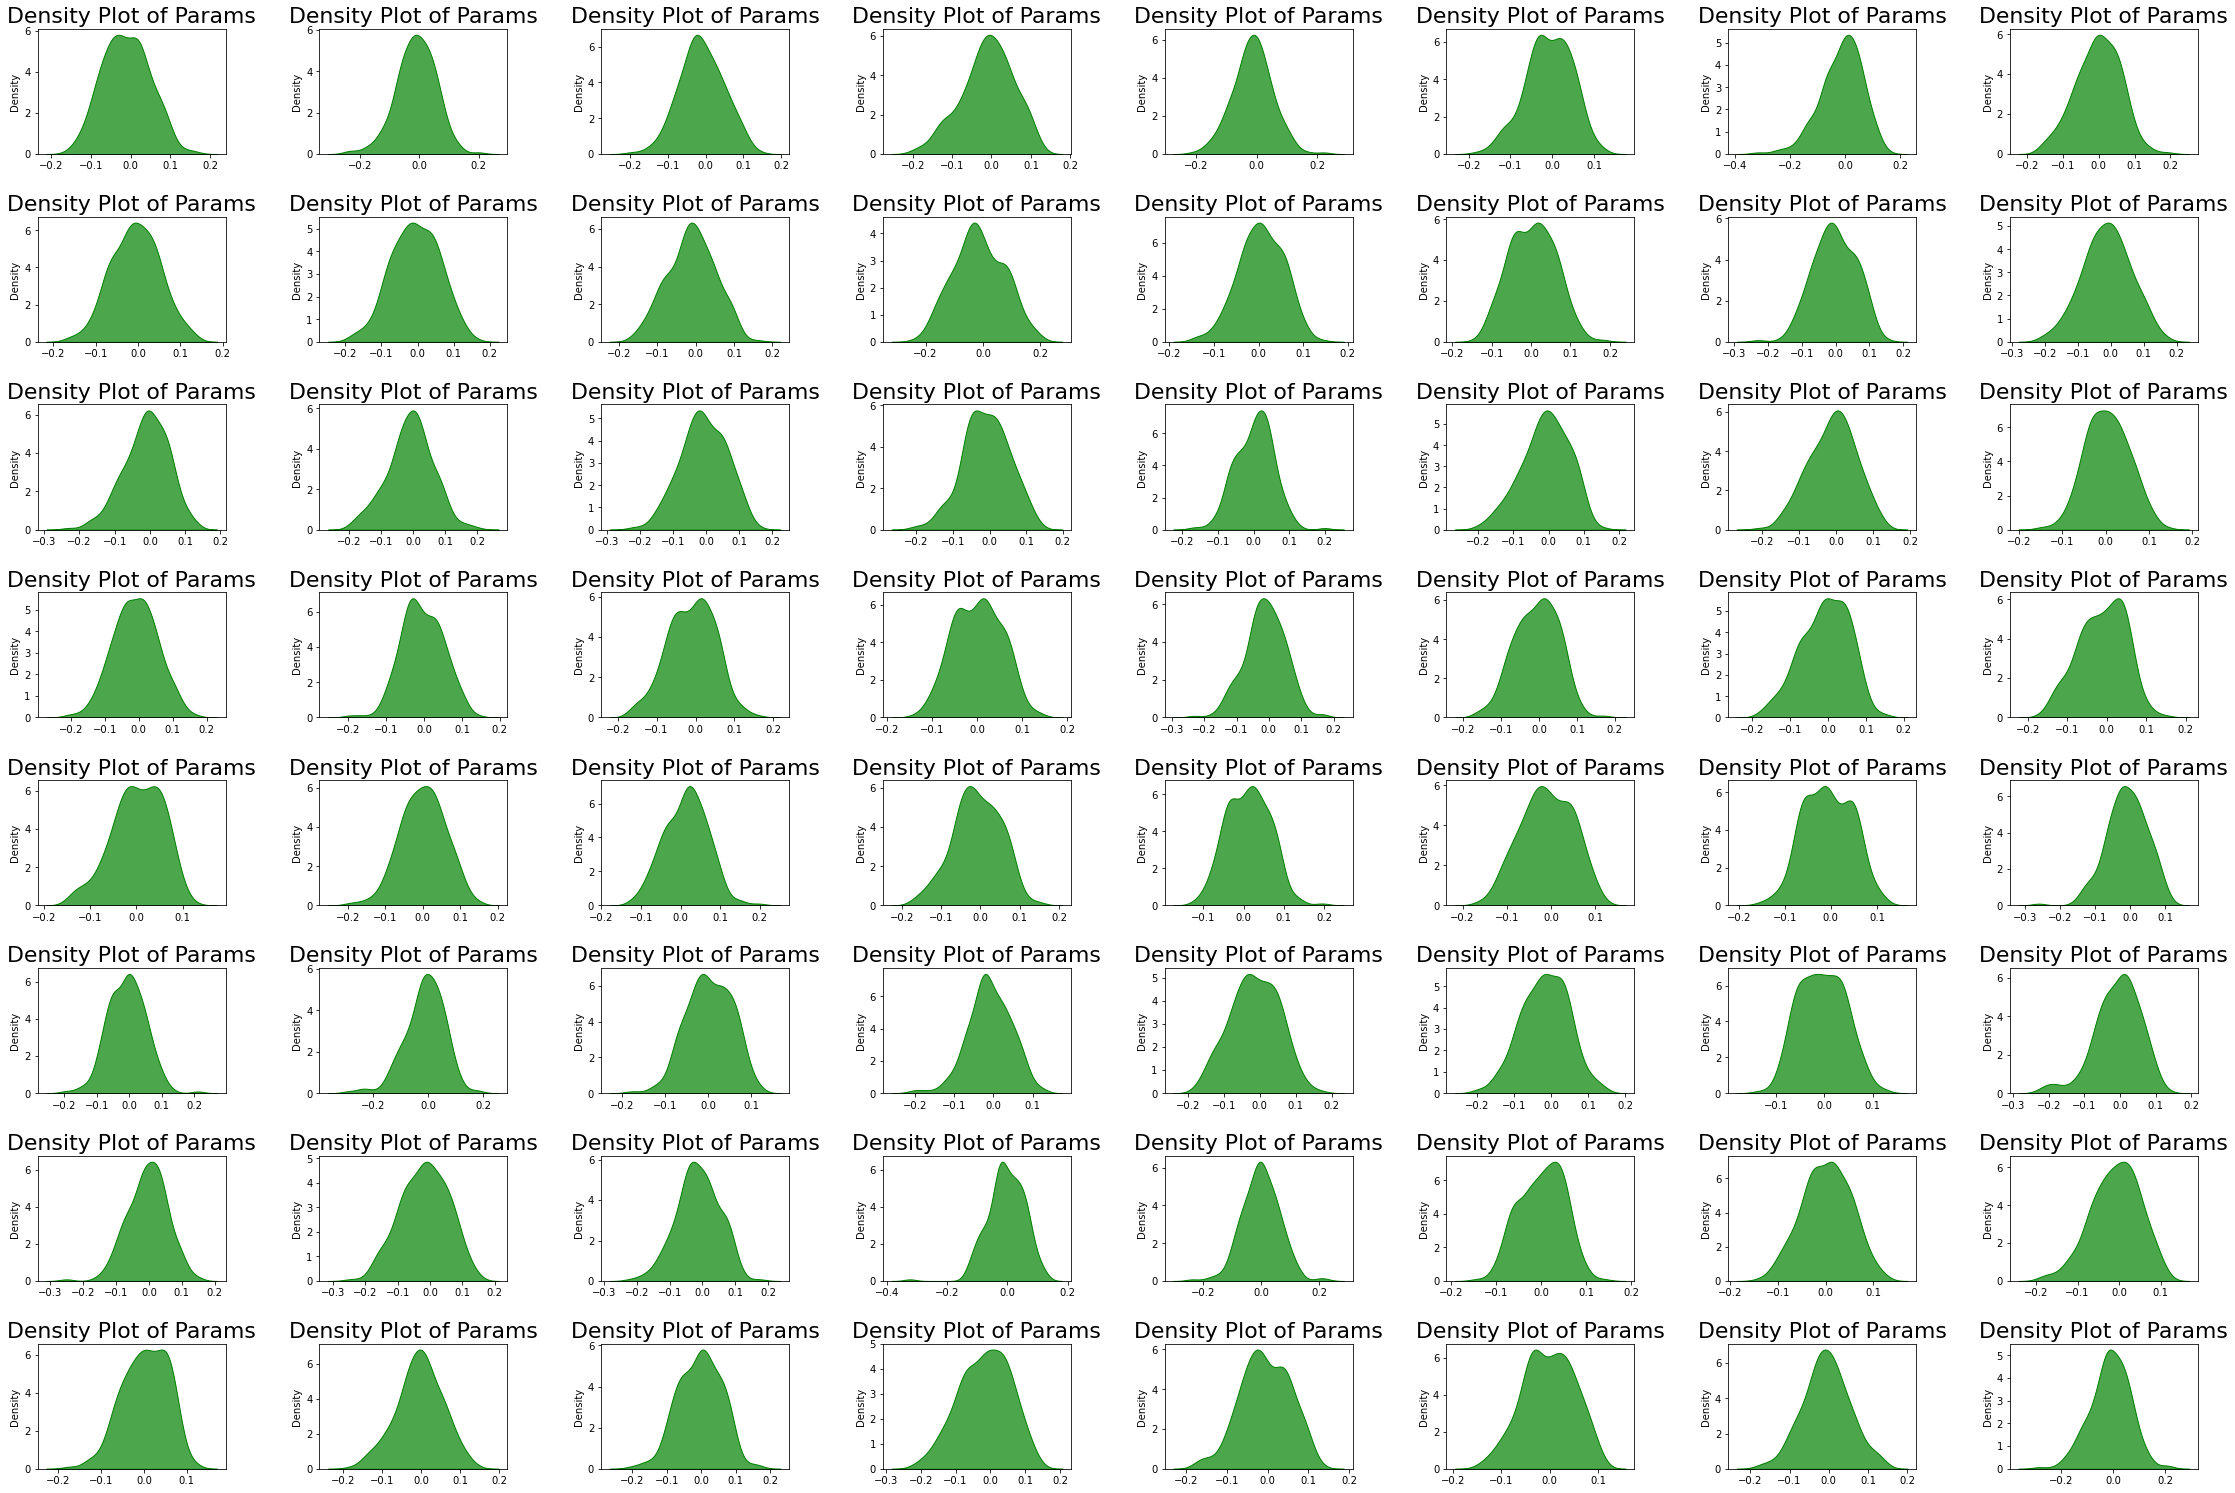

In [23]:
layer4 = model.cnn[9].weight.view((64,32*7)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(64):
    plt.subplot(8, 8, i+1)
    sns.kdeplot(layer4[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

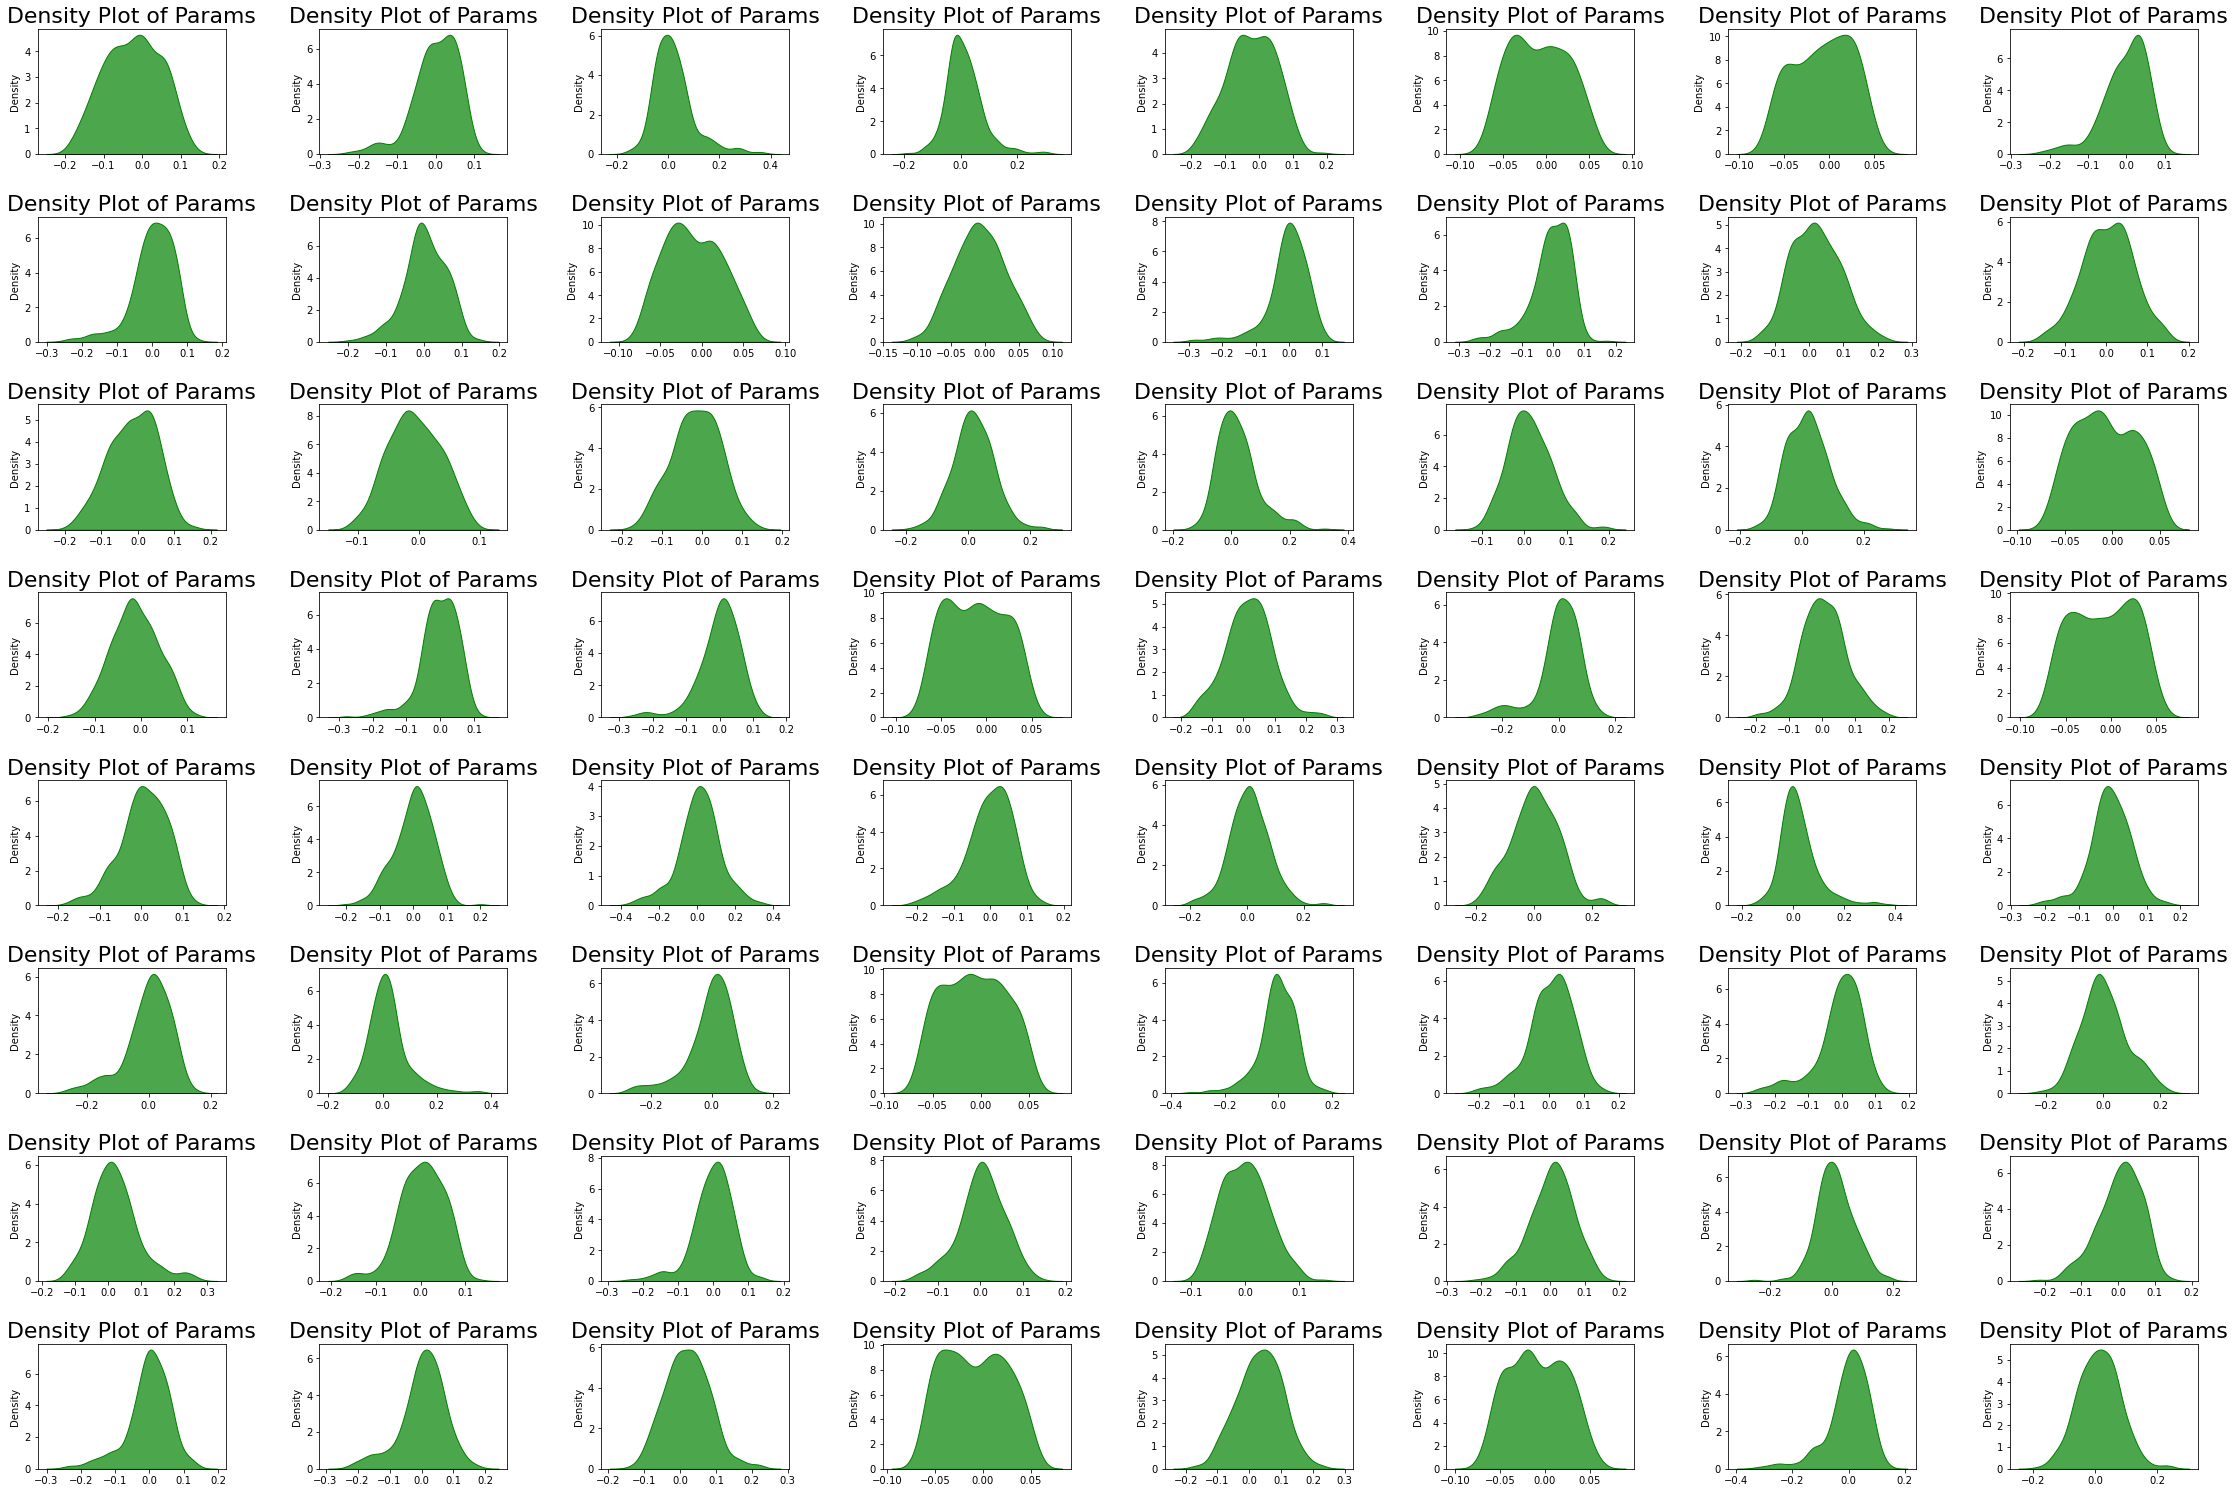

In [24]:
layer5 = model.cnn[12].weight.view((64,64*5)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(64):
    plt.subplot(8, 8, i+1)
    sns.kdeplot(layer5[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

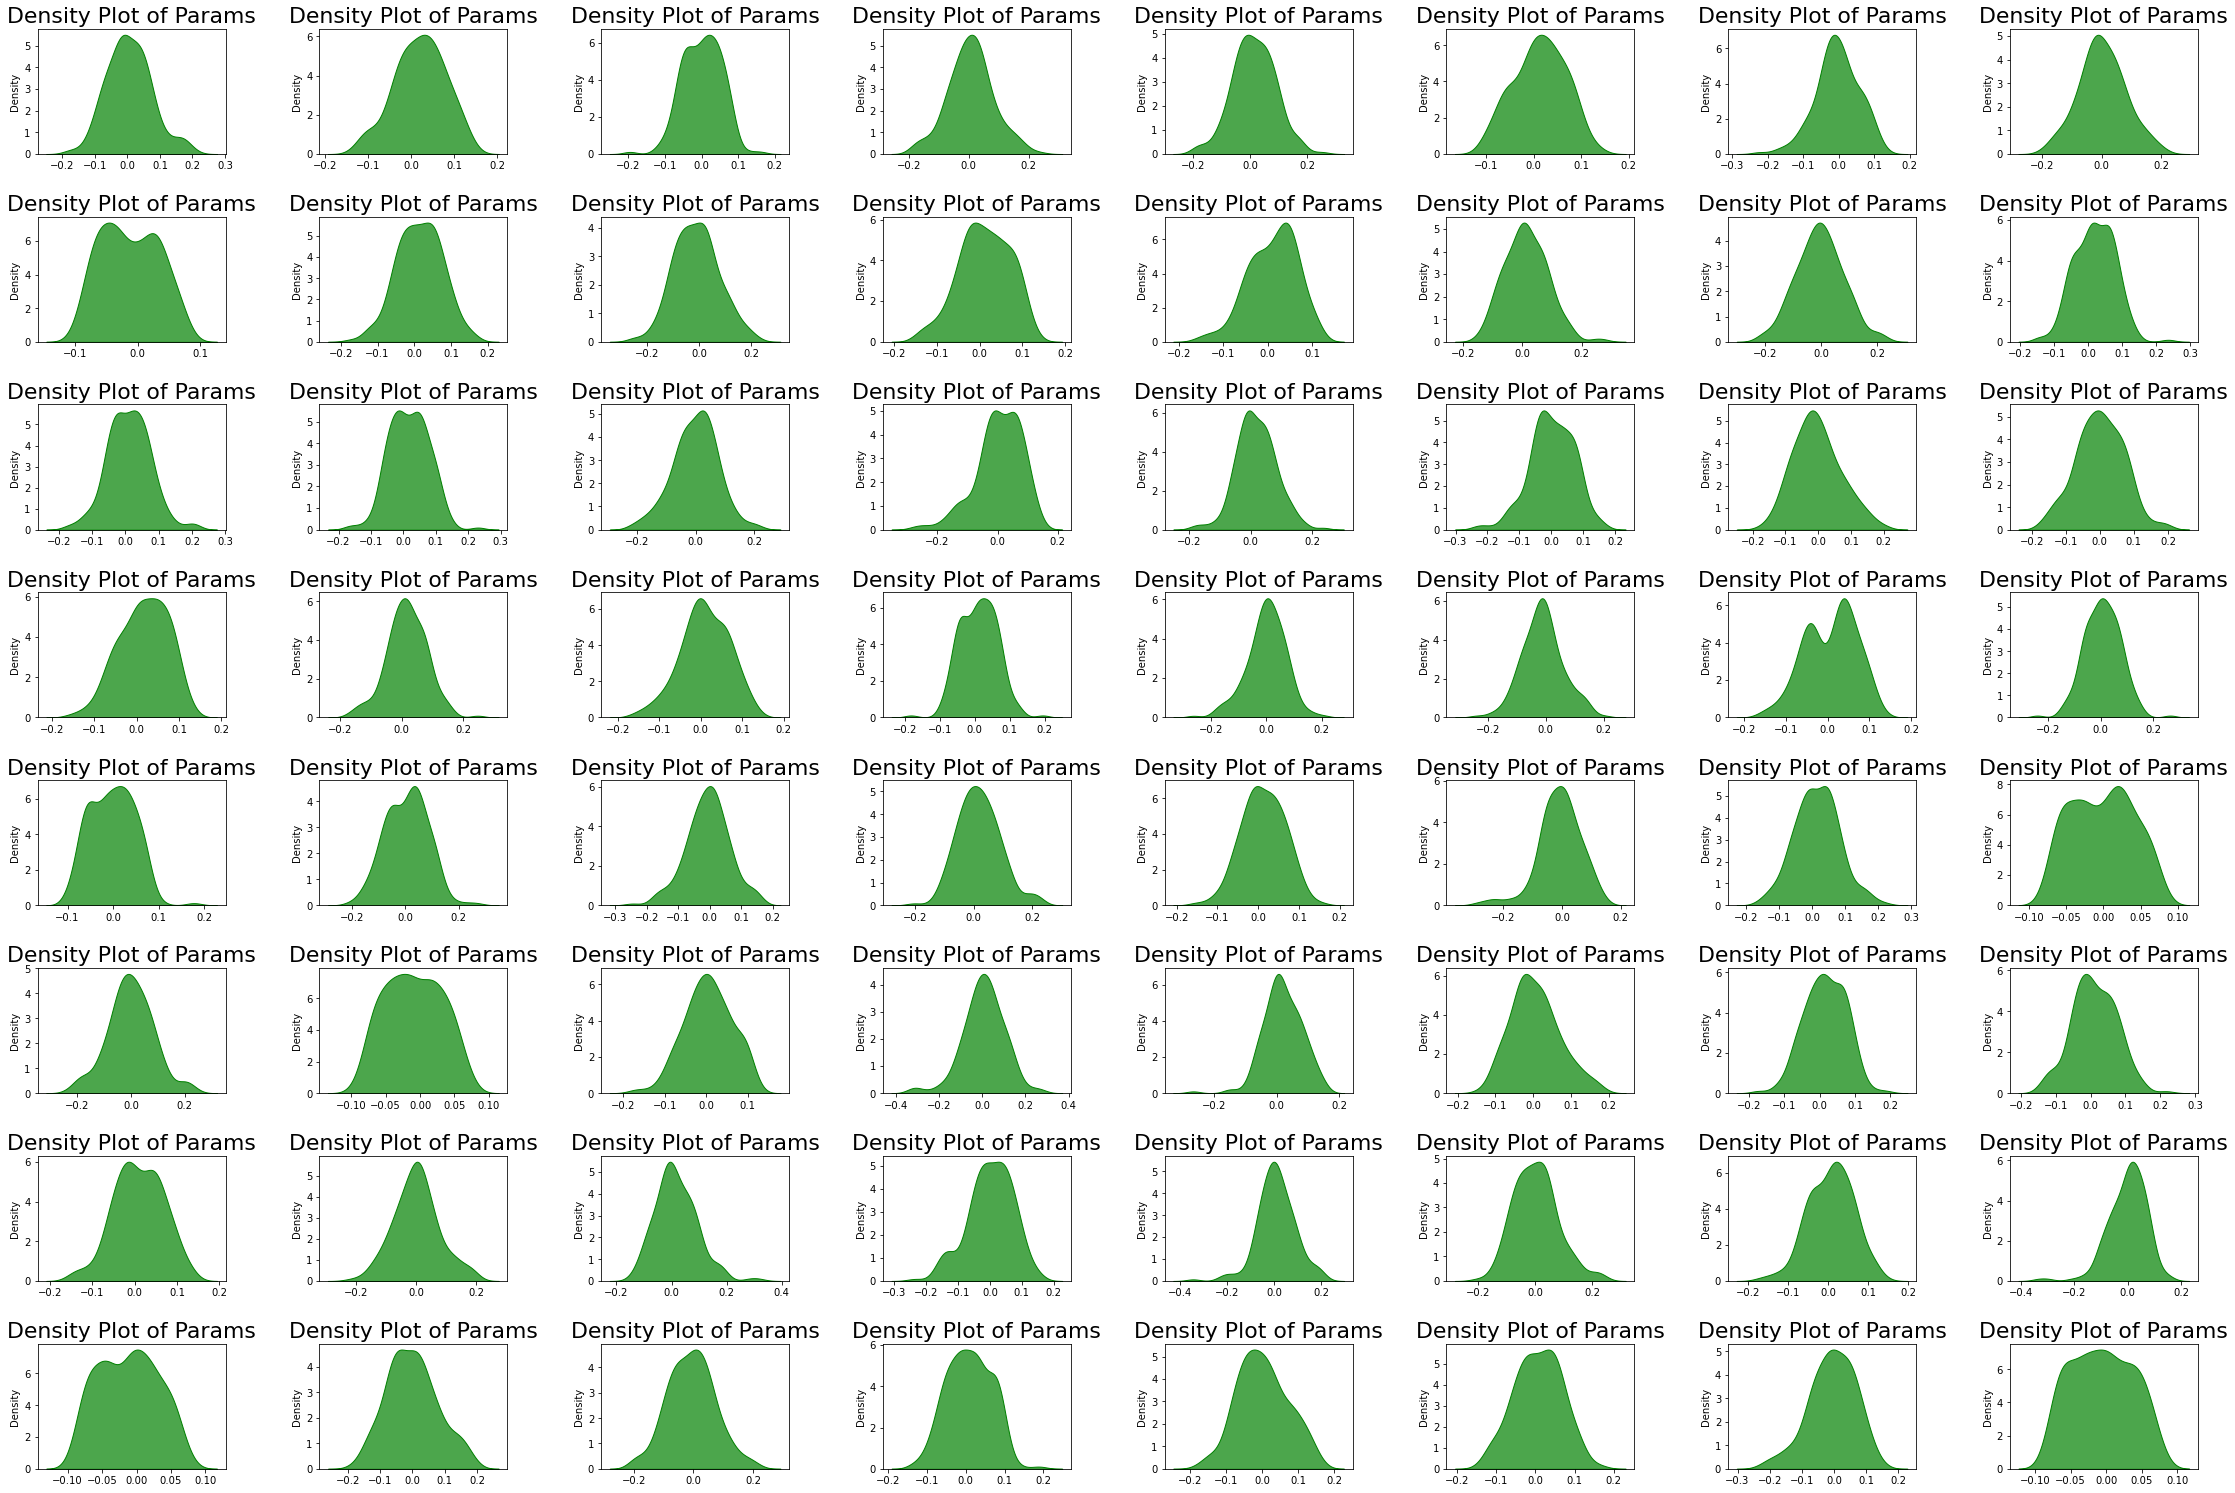

In [25]:
layer6 = model.cnn[15].weight.view((64,64*3)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(64):
    plt.subplot(8, 8, i+1)
    sns.kdeplot(layer6[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

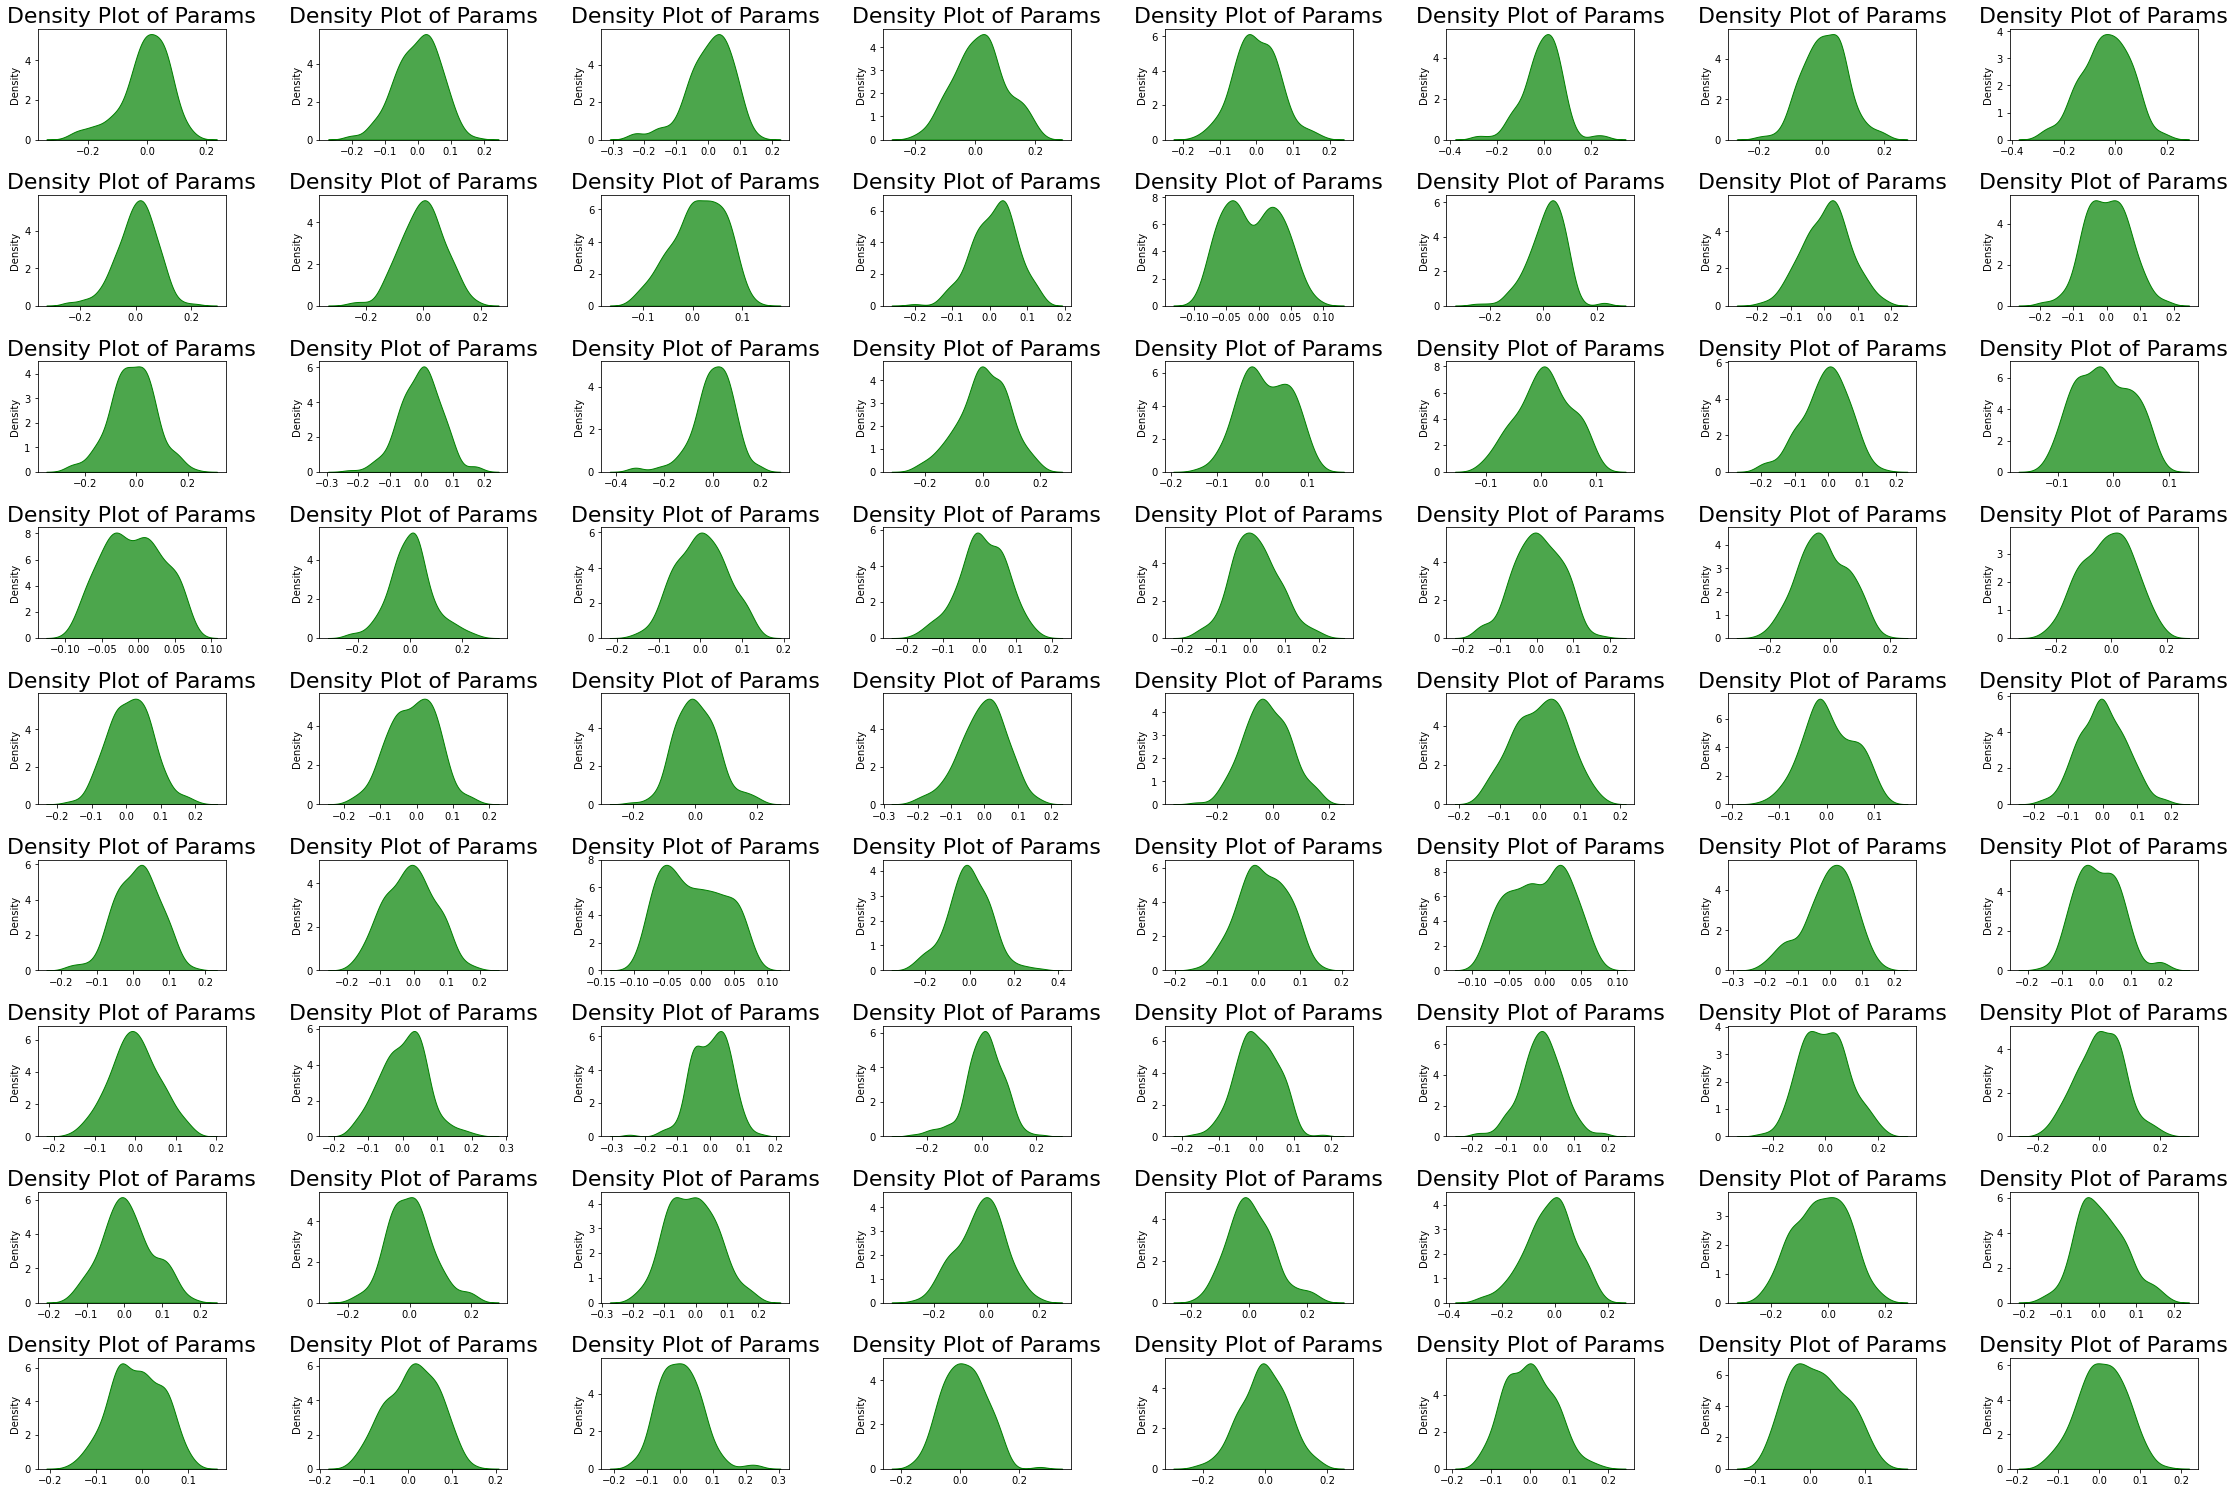

In [26]:
layer7 = model.cnn[18].weight.view((72,64*3)).to("cpu").detach().numpy()
plt.subplots_adjust(left=0, bottom=0, right=5, top=5,
                wspace=0.5, hspace=0.5)
for i in range(72):
    plt.subplot(9, 8, i+1)
    sns.kdeplot(layer7[i], shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

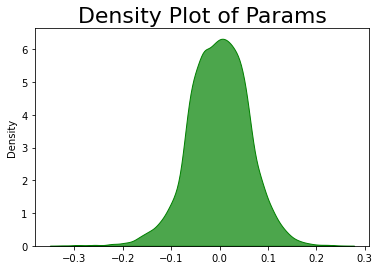

In [27]:
layer8 = model.cnn[22].weight.view((64*216)).to("cpu").detach().numpy()
for i in range(1):
    plt.subplot(1, 1, i+1)
    sns.kdeplot(layer8, shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

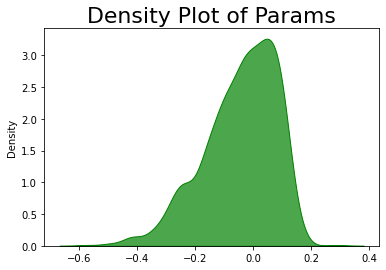

In [28]:
layer9 = model.cnn[25].weight.view((64*17)).to("cpu").detach().numpy()
for i in range(1):
    plt.subplot(1, 1, i+1)
    sns.kdeplot(layer9, shade=True, color="g", alpha=.7)
    plt.title('Density Plot of Params', fontsize=22)
plt.show()

In [31]:
model

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(2,), padding=(7,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(8, 12, kernel_size=(12,), stride=(2,), padding=(5,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(12, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


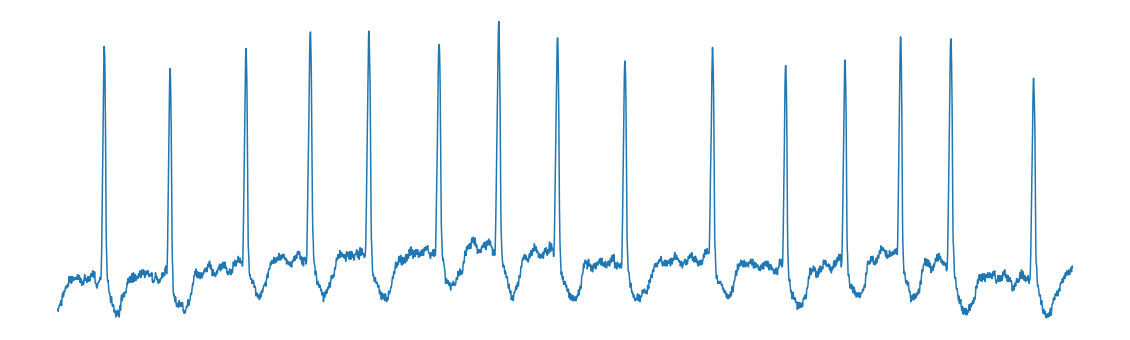

In [70]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
    
X=np.array(X)
y=np.array(y)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))
t=np.arange(3600)
p = X_train[1,:,:].reshape((3600))
plt.figure(figsize=(20,6))
plt.plot(t,p)
plt.grid()
plt.axis("off")
plt.savefig(fname="ECGNet.pdf",format="pdf")


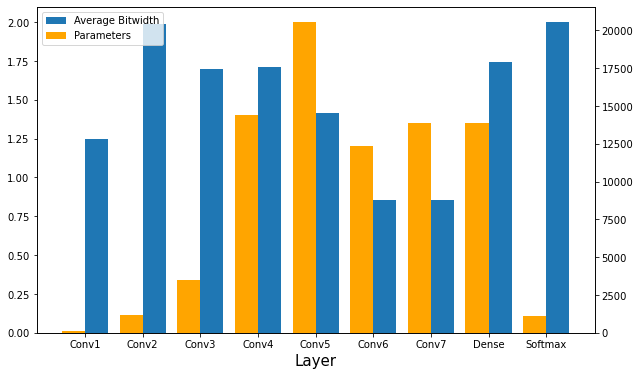

In [2]:
import matplotlib.pyplot as plt
import numpy as np
x1 = ['Conv1','Conv2','Conv3','Conv4','Conv5','Conv6','Conv7','Dense','Softmax']
y1=[136,1164,3488,14400,20544,12352,13896,13888,1105]
x = np.arange(len(x1))
y2=[1.25,1.9896,1.7005,1.7095,1.4133,0.8545,0.8550,1.7422,2.0]
fig = plt.figure(figsize=(10,6))
width=0.4
ax1 = fig.add_subplot(111)
a = ax1.bar(x+0.2,y2,width,label = 'Average Bitwidth')

ax2 = ax1.twinx()
b = ax2.bar(x-0.2,y1,width,label ='Parameters', color='orange')
plt.xticks(x, labels=x1)
plt.xlabel('Layers')
plt.legend(handles=[a,b],loc='upper left')
ax1.set_xlabel("Layer",fontsize=15)
plt.savefig(fname="bar.pdf",format="pdf")